# 1. IMPORT LIBRARIES

In [1]:
!pip install -q datasets
!pip install -q transformers==4.33.1


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gc
from torch.cuda.amp import autocast, GradScaler


from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, OPTForCausalLM, GPT2Tokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:

!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter


Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpnxeay54g".


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## 2. SET MAIN INPUTS FOR NOTEBOOK

In [4]:
bx_size = 1                                 # batch size for inference with the OPT
format_train_val = 'gpt3'                   # 'minimal' or 'gpt3
task_name = 'mnli'                          # 'mnli'
model_name = "facebook/opt-1.3b"            # model options below
examples_per_exp =  16                       # 16
num_experiments = 10                         # 10
num_validations = 1024                      # number of validations
num_reasoning_context_per_example = 16

# for context distillation
number_max_probs_match = 50
SEL_EXP_TRAIN_CD = 1


# model_name = "facebook/opt-125m"
# model_name = "facebook/opt-350m"
# model_name = "facebook/opt-1.3b"
# model_name = "facebook/opt-2.7b"
# model_name = "facebook/opt-6.7b"

## 3. SET DEVICE

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
import torch

# Check if CUDA (GPU support) is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

# If CUDA is available, print the GPU name(s)
if cuda_available:
    print(f"GPU Name(s): {torch.cuda.get_device_name(0)}")

CUDA Available: True
GPU Name(s): NVIDIA A100-SXM4-40GB


In [7]:
device = torch.device("cuda")

device_count = torch.cuda.device_count()
if device_count > 0:
    print("Select GPU device")
    device = torch.device("cuda")
else:
    print("Select GPU device")
    device = torch.device("cpu")

print(device)
torch.cuda.is_available()

Select GPU device
cuda


True

## 4. IMPORT TOKENIZER AND INSTANTIATE MODEL

In [8]:
# Choose model to work with:

# model_name = "facebook/opt-125m"
# model_name = "facebook/opt-350m"
# model_name = "facebook/opt-1.3b"
# model_name = "facebook/opt-2.7b"
# model_name = "facebook/opt-6.7b"

model_name = model_name # it is set up in top of NB

In [9]:
OPT_tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

In [10]:
# Create class as myBaseOPT_ICL to work with in-context learning set up

class myBaseOPT_CD(nn.Module):

  def __init__(self, load_model_name = "facebook/opt-350m",model_max_tokens=2048, device = 'cuda'):
    super(myBaseOPT_CD, self).__init__()

    self.model_max_tokens = model_max_tokens
    self.device = device

    self.coreOPT = OPTForCausalLM.from_pretrained(
    load_model_name,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    ).model

    self.lm_OPT_head = OPTForCausalLM.from_pretrained(
    load_model_name,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    ).lm_head

  def forward(self, src, attention_mask):


    return self.lm_OPT_head.forward(self.coreOPT.forward(
        src,
        attention_mask=attention_mask
    )['last_hidden_state'])

  def forward_generate(self, src, attention_mask):


    return self.lm_OPT_head.forward(self.coreOPT.forward(
        src,
        attention_mask=attention_mask
    )['last_hidden_state'])


  def generate_text(self, src_inputs, src_attn, gen_tokens=torch.tensor(1)):


    src_len = src_inputs.shape[1]

    gen_tokens = gen_tokens.item()


    outputs = torch.zeros((src_inputs.shape[0], src_inputs.shape[1] + gen_tokens), dtype=torch.long).to(self.device)
    att_mask = torch.zeros((src_attn.shape[0], src_attn.shape[1] + gen_tokens), dtype=torch.long).to(self.device)

    outputs[:,0:src_inputs.shape[1]] = src_inputs
    att_mask[:,0:src_attn.shape[1]] = src_attn

    for t_step in range(gen_tokens):

      all_scores = self.forward_generate(outputs[:,0:src_inputs.shape[1]+t_step], att_mask[:,0:src_attn.shape[1]+t_step])

      new_tokens = torch.argmax(all_scores[:,-1,:], dim=1)

      outputs[:,src_inputs.shape[1]+t_step] = new_tokens
      att_mask[:,src_attn.shape[1]+t_step] = 1

    # Yes token = 9904
    # No token = 3084
    binary_yes_no = torch.zeros(all_scores.shape[0]).half().to(self.device)
    binary_yes_no[:] = all_scores[:,-1,9904] - all_scores[:,-1,3084]

    binary_yes_no[binary_yes_no >= 0] = 0 # or 9904 if token used "Yes"
    binary_yes_no[binary_yes_no < 0] = 1 # or 3084 if token used "No"

    last_scores = all_scores[:,-1,:]

    return outputs, binary_yes_no, last_scores


In [11]:
# Instantiate model and send to selected device
example_myBaseOPT_CD = myBaseOPT_CD(load_model_name = model_name, device = device)
example_myBaseOPT_CD.half()
example_myBaseOPT_CD.to(device)

for param in example_myBaseOPT_CD.parameters():
  if param.ndim <=2:
    param.data = param.data.to(torch.float32)

example_myBaseOPT_CD

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

myBaseOPT_CD(
  (coreOPT): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2048, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2048)
      (final_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
          (final_layer_norm): LayerN

In [12]:
# Check total number of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Parameters: ", count_parameters(example_myBaseOPT_CD))

Model Parameters:  1418715136


In [13]:
# Check base model output correctness (from OPT HF example)
prompt_example = ("A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the "
              "Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived "
              "there?")
prompt_example_tokenized = OPT_tokenizer(prompt_example )
example_myBaseOPT_CD.eval()
outputs_ex_sp, binary_ex_sp, scores_ex_sp = example_myBaseOPT_CD.generate_text(src_inputs = torch.unsqueeze(torch.tensor(prompt_example_tokenized['input_ids']),0).to(device),
                                    src_attn = torch.unsqueeze(torch.tensor(prompt_example_tokenized['attention_mask']),0).to(device),
                                    gen_tokens=torch.tensor(100).to(device))
OPT_tokenizer.batch_decode(outputs_ex_sp)



['</s>A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived there?\nStatue: I have lived here for over 100 years.\nHuman: What do you do?\nStatue: I am a tourist attraction.\nHuman: What do you do when you are not a tourist attraction?\nStatue: I am a tourist attraction.\nHuman: What do you do when you are not a tourist attraction?\nStatue: I am a tourist attraction.\nHuman: What do you do when you are not a tourist attraction?\nStatue:']

## 4. IMPORT NLI DATASET FOR TRAINING AND VALIDATION: MNLI

In [14]:
device = torch.device("cpu")

In [15]:
# reference: https://github.com/uds-lsv/llmft/blob/main/notebooks/majority_baseline.ipynb
# this reference is useful for cleaning the neutral sentences of the dataset, just keeping the 0 and 1.

In [16]:
from collections import Counter
from datasets import load_dataset, ClassLabel

In [17]:
# this comes from original paper, to remove neutral examples from MNLI
def binarize_mnli(dataset, remove_neutral=True):
    if remove_neutral:
        # neutral class has label 1
        dataset = dataset.filter(lambda example: example["label"] != 1)

    # change labels of contradiction examples from 2 to 1
    def change_label(example):
        # convert labels 2 into labels 1. this merges the neutral and contradiction class
        example["label"] = 1 if example["label"] == 2 else example["label"]
        return example

    # change labels
    dataset = dataset.map(change_label)

    # change features to reflect the new labels
    features = dataset["train"].features.copy()
    features["label"] = ClassLabel(num_classes=2, names=['entailment', 'contradiction'], id=None)
    dataset = dataset.cast(features)  # overwrite old features

    return dataset


In [18]:
# Select GLUE task (set it at the top of NB for simplicity with all other inputs)

# task_name = "rte"
# task_name = "mnli"
# task_name = "qqp"
# task_name = "cola"

task_name = task_name

In [19]:
dataset = load_dataset("glue", task_name)

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [20]:
# binarize dataset
if task_name == "mnli":
    dataset = binarize_mnli(dataset, remove_neutral=True) # mnli


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

Map:   0%|          | 0/261802 [00:00<?, ? examples/s]

Map:   0%|          | 0/6692 [00:00<?, ? examples/s]

Map:   0%|          | 0/6703 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/261802 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6692 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6703 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9796 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [21]:
# analyze and visualize dataset imported

print("task_name:", task_name)
# for split in ["train", "validation"]:
for split in ["train", "validation_matched"]:
    c = Counter(dataset[split]["label"])
    total = len(list(c.elements()))
    print("Total number of samples:", total)
    print(split)
    for k in c:
        print(f"fraction of labels per class: {k}={c[k] / total}")
print(dataset)

task_name: mnli
Total number of samples: 261802
train
fraction of labels per class: 0=0.49999236063895613
fraction of labels per class: 1=0.5000076393610439
Total number of samples: 6692
validation_matched
fraction of labels per class: 1=0.4801255230125523
fraction of labels per class: 0=0.5198744769874477
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 261802
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6692
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6703
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


In [22]:
# Perform the filters and splits from the original datasets


random_split_seed = 42

examples_per_exp =  examples_per_exp # 16
num_experiments = num_experiments # 10
num_validations = num_validations # 16*64 #64*16 = 1024 #6692

max_train_samples = examples_per_exp*num_experiments
train_dataset = dataset['train']
print(train_dataset)

train_dataset_yes_all = dataset['train'].filter(lambda example: example["label"] == 0)
train_dataset_no_all = dataset['train'].filter(lambda example: example["label"] == 1)
print(train_dataset_yes_all)
print(train_dataset_no_all)

val_dataset_all = dataset['validation_matched']

# randomly select a subset of the training data
max_train_samples = min(len(train_dataset), max_train_samples)

np.random.seed(random_split_seed)
indices_yes = np.random.choice(range(len(train_dataset_yes_all)), size=int(max_train_samples/2), replace=False)
print("indices_yes: ", indices_yes)

np.random.seed(random_split_seed+1)
indices_no = np.random.choice(range(len(train_dataset_no_all)), size=int(max_train_samples/2), replace=False)
print("indices_no: ", indices_no)

np.random.seed(random_split_seed+2)
indices_val = np.random.choice(range(len(val_dataset_all)), size=num_validations, replace=False)
print("indices_val: ", indices_val)

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})


Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130899
})
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130903
})
indices_yes:  [108195  86013  39482  39689  10288  11589  94511  78690  36953  74067
  93678  83921  83896  21665  76736    651  48482  40811 127490  49367
 121664  39918  60933 126502  65765  12966  33438   7201  19815  49187
  29116  48565 125127  60274  33985 130032 104535 120345 104033  44914
  89806  87143 103906  15697  29521   4906  46884  75442  57625  32365
  70562  78463  18684  45639  30223 118624  40945  75797  63681  77117
  16126 130579   2132 113346  68080   7433 120366 122242  75493  64389
  95467  86480  52323  42308 101738  51386 126981  27346  45655 121440]
indices_no:  [ 54039  34647  34994 102702  14063 110662  33077  24477  24337  19083
  61263 109299 107760  88071  22063  90740 113958   9163  45235  32885
  58399  59560 102582  10964  38283  16146  72067  55788  60576  21220
  41478 1

In [23]:
train_dataset_yes = train_dataset_yes_all.select(indices_yes)
train_dataset_no = train_dataset_no_all.select(indices_no)

val_dataset = val_dataset_all.select(indices_val)
print("Train Dataset Yes: ", train_dataset_yes)
print("Train Dataset No: ", train_dataset_no)
print("Validation Dataset (in-domain): ", val_dataset)

Train Dataset Yes:  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 80
})
Train Dataset No:  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 80
})
Validation Dataset (in-domain):  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 1024
})


In [24]:

# Combine indices of selected subsets

used_indices_yes_no = train_dataset_yes['idx'] + train_dataset_no['idx']

train_ind_remaining = [i for i, element in enumerate(train_dataset['idx']) if element not in used_indices_yes_no]

train_dataset_remaining = train_dataset.select(train_ind_remaining)

print("train_dataset_remaining:", len(train_dataset_remaining))
print(train_dataset_remaining)

train_dataset_remaining_yes_all = train_dataset_remaining.filter(lambda example: example["label"] == 0)
train_dataset_remaining_no_all = train_dataset_remaining.filter(lambda example: example["label"] == 1)

print("train_dataset_remaining_yes_all:", len(train_dataset_remaining_yes_all))
print(train_dataset_remaining_yes_all)

print("train_dataset_remaining_no_all:", len(train_dataset_remaining_no_all))
print(train_dataset_remaining_no_all)



train_dataset_remaining: 261642
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261642
})


Filter:   0%|          | 0/261642 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261642 [00:00<?, ? examples/s]

train_dataset_remaining_yes_all: 130819
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130819
})
train_dataset_remaining_no_all: 130823
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130823
})


In [25]:
num_reasoning_context_per_example = num_reasoning_context_per_example
total_to_select_CD_YES = int(num_experiments*examples_per_exp*num_reasoning_context_per_example/2)
total_to_select_CD_NO = int(num_experiments*examples_per_exp*num_reasoning_context_per_example/2)
print("total_to_select_CD_YES: ", total_to_select_CD_YES)
print("total_to_select_CD_NO: ", total_to_select_CD_NO)

total_to_select_CD_YES:  1280
total_to_select_CD_NO:  1280


In [26]:
random_split_seed_CD = 100

num_reasoning_context_per_example = num_reasoning_context_per_example
total_to_select_CD_YES = int(num_experiments*examples_per_exp*num_reasoning_context_per_example/2)
total_to_select_CD_NO = int(num_experiments*examples_per_exp*num_reasoning_context_per_example/2)
print("total_to_select_CD_YES: ", total_to_select_CD_YES)
print("total_to_select_CD_NO: ", total_to_select_CD_NO)

np.random.seed(random_split_seed_CD)
indices_rem_yes = np.random.choice(range(len(train_dataset_remaining_yes_all)), size=total_to_select_CD_YES, replace=False)
print("indices_yes: ", indices_yes)

np.random.seed(random_split_seed_CD+1)
indices_rem_no = np.random.choice(range(len(train_dataset_remaining_no_all)), size=total_to_select_CD_NO, replace=False)
print("indices_no: ", indices_no)

train_dataset_CD_yes = train_dataset_remaining_yes_all.select(indices_rem_yes)
train_dataset_CD_no = train_dataset_remaining_no_all.select(indices_rem_no)

print("Train Dataset CD Yes: ", train_dataset_CD_yes)
print("Train Dataset CD No: ", train_dataset_CD_no)

total_to_select_CD_YES:  1280
total_to_select_CD_NO:  1280
indices_yes:  [108195  86013  39482  39689  10288  11589  94511  78690  36953  74067
  93678  83921  83896  21665  76736    651  48482  40811 127490  49367
 121664  39918  60933 126502  65765  12966  33438   7201  19815  49187
  29116  48565 125127  60274  33985 130032 104535 120345 104033  44914
  89806  87143 103906  15697  29521   4906  46884  75442  57625  32365
  70562  78463  18684  45639  30223 118624  40945  75797  63681  77117
  16126 130579   2132 113346  68080   7433 120366 122242  75493  64389
  95467  86480  52323  42308 101738  51386 126981  27346  45655 121440]
indices_no:  [ 54039  34647  34994 102702  14063 110662  33077  24477  24337  19083
  61263 109299 107760  88071  22063  90740 113958   9163  45235  32885
  58399  59560 102582  10964  38283  16146  72067  55788  60576  21220
  41478 123489  38278  15117  71374  69791  39777 122448  10098  35761
  74547 109598  19072  61567  56626 102957  18014  14118  462

In [27]:
# Calculate the number of 0 and 1 in validation dataset
# and calculate the majority class accuracy

val_dataset_yes = val_dataset.filter(lambda example: example["label"] == 0)
val_dataset_no = val_dataset.filter(lambda example: example["label"] == 1)
print(val_dataset_yes)
print(val_dataset_no)
print("Majority Class Accuracy: ", 100*max(len(val_dataset_yes), len(val_dataset_no))/(len(val_dataset_yes) + len(val_dataset_no)))

Filter:   0%|          | 0/1024 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1024 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 536
})
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 488
})
Majority Class Accuracy:  52.34375


In [28]:

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place


def format_examples_CD_train(example_train, format_train=format_train_val):
    # format examples of train data for ICL
    # select format

    if format_train == 'minimal':
      # "minimal" format
      if example_train['label'] == 0:
        return {'text': "{"  + example_train['premise'] + "} {" + example_train['hypothesis'] + "}" + " ? ĠYes \n\n"}
      elif example_train['label'] == 1:
        return {'text': "{"  + example_train['premise'] + "} {" + example_train['hypothesis'] + "}" + " ? ĠNo \n\n"}
    elif format_train == 'gpt3':
      # "gpt-3" format
      if example_train['label'] == 0:
        return {'text': "{"  + example_train['premise'] + "} question: {" + example_train['hypothesis'] + "}" + " Yes or No? answer: ĠYes \n\n"}
      elif example_train['label'] == 1:
        return {'text': "{"  + example_train['premise'] + "} question: {" + example_train['hypothesis'] + "}" + " Yes or No? answer: ĠNo \n\n"}

def format_examples_train(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset(train_ds_yes, train_ds_no, context_ds_yes, context_ds_no, num_expts=num_experiments, num_train_examples=examples_per_exp, num_contxt_dist_examples = num_reasoning_context_per_example):
    combined_dataset = []
    train_examples_yes = [example for example in train_ds_yes]
    train_examples_no = [example for example in train_ds_no]
    context_examples_yes = [example for example in context_ds_yes]
    context_examples_no = [example for example in context_ds_no]

    for irep in range(num_expts):
    # ELIMINATE THIS FOR LOOP: for val_ex in val_dataset:
          sampled_train_exs_yes = train_examples_yes[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          sampled_train_exs_no = train_examples_no[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          # for random option if used below
          merged_sampled_train_exs = sampled_train_exs_yes + sampled_train_exs_no
          shuffled_list = merged_sampled_train_exs.copy()
          # Shuffle the copy
          random.seed(irep)
          random.shuffle(shuffled_list)

          # RETHINK THIS, MOVE INSIDE NEXT FOR LOOP
          # combined_ex = {'text': '', 'label': val_ex['label'], 'exp': irep}

          # Way 1: set examples Yes, No, Yes, No, ...
          '''
          for idx_train in range(len(sampled_train_exs_yes)):
            # put order one Yes and another No consecutively
            combined_ex['text'] += sampled_train_exs_yes[idx_train]['text']
            combined_ex['text'] += sampled_train_exs_no[idx_train]['text']
          '''

          # Way 2: set randomized
          for idx_shuffled_list in range(len(shuffled_list)):

            sampled_context_exs_yes = context_examples_yes[int(irep*num_train_examples*num_contxt_dist_examples/2 + idx_shuffled_list*num_contxt_dist_examples/2) : int(irep*num_train_examples*num_contxt_dist_examples/2 + (idx_shuffled_list+1)*num_contxt_dist_examples/2)]
            sampled_context_exs_no = context_examples_no[int(irep*num_train_examples*num_contxt_dist_examples/2 + idx_shuffled_list*num_contxt_dist_examples/2) : int(irep*num_train_examples*num_contxt_dist_examples/2 + (idx_shuffled_list+1)*num_contxt_dist_examples/2)]

            # print-out to check indexes and selection of lists is correct
            # commented out for production
            '''
            print("irep:" , irep,
                  "idx_shuffled_list: ", idx_shuffled_list,
                  "idx_init: ", int(irep*num_train_examples*num_contxt_dist_examples/2 + idx_shuffled_list*num_contxt_dist_examples/2),
                  "idx_end: ", int(irep*num_train_examples*num_contxt_dist_examples/2 + (idx_shuffled_list+1)*num_contxt_dist_examples/2),
                  "sampled_context_exs_yes: ", len(sampled_context_exs_yes),
                  "sampled_context_exs_no: ", len(sampled_context_exs_no))
            '''
            # random option
            merged_sampled_context_exs = sampled_context_exs_yes + sampled_context_exs_no
            context_shuffled_list = merged_sampled_context_exs.copy()
            # Shuffle the copy
            random.seed(idx_shuffled_list)
            random.shuffle(context_shuffled_list)

            combined_ex = {'text': '', 'label': shuffled_list[idx_shuffled_list]['label'], 'exp': irep+1, 'OPT_prob_CD': torch.zeros(0).half().to(device), 'OPT_idx_CD': torch.zeros(0).half().to(device)}

            for example_context_shuffled_list in context_shuffled_list:

                combined_ex['text'] += example_context_shuffled_list['text']

            # MOVED INTO FOR LOOP: Add the example to predict (validation)
            combined_ex['text'] += shuffled_list[idx_shuffled_list]['text']

            # MOVED INTO FOR LOOP: Append the new combined example to the combined dataset
            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn(batch):
    # This function is created to be able to tokenize dynamically to max length within each batch
    # Also, by modifying the tokenizer used, several other options are available
    # for example, if we set padding to a specified max_length, for example the model max_length, is also an option, not the default though
    # the default is the dynamic padding

    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]
    OPT_probs_cd = [item['OPT_prob_CD'] for item in batch]
    OPT_idxs_cd = [item['OPT_idx_CD'] for item in batch]
    #print("LIST OPT_probs_cd:", OPT_probs_cd)
    #print("LIST OPT_idxs_cd:", OPT_idxs_cd)

    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
    # tokenized_inputs = OPT_tokenizer(texts, padding="max_length", max_length = 2048, truncation=True, return_tensors="pt")

    labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)
    exps_tensor = torch.tensor(exps, dtype=torch.long).to(device)
    OPT_probs_cd_tensor = torch.cat(OPT_probs_cd, dim=0)
    #print("DYN PAD FN - OPT_probs_cd_tensor SHAPE:", OPT_probs_cd_tensor.shape)
    #print("DYN PAD FN - OPT_probs_cd_tensor:", OPT_probs_cd_tensor)

    OPT_idxs_cd_tensor = torch.cat(OPT_idxs_cd, dim=0)
    #print("DYN PAD FN - OPT_idxs_cd_tensor SHAPE:", OPT_idxs_cd_tensor.shape)
    #print("DYN PAD FN - OPT_idxs_cd_tensor:", OPT_idxs_cd_tensor)

    # return here the outputs desired
    # we have chosen the input_ids, attention_mask, label of the validation samples
    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels_tensor,
        'exps': exps_tensor,
        'OPT_probs': OPT_probs_cd_tensor,
        'OPT_idxs': OPT_idxs_cd_tensor,
    }

class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [29]:
# First the samples are formatted according to selection above
# Important to check selection and re-run cell above so that it is taken by the mapping function correctly

formatted_train_dataset_yes = train_dataset_yes.map(format_examples_train)
formatted_train_dataset_no = train_dataset_no.map(format_examples_train)
formatted_train_CD_dataset_yes = train_dataset_CD_yes.map(format_examples_CD_train)
formatted_train_CD_dataset_no = train_dataset_CD_no.map(format_examples_CD_train)

# Initialize custom dataset with the combined dataset
# print result to check correctness

combined_dataset = create_combined_dataset(
                                          train_ds_yes = formatted_train_dataset_yes,
                                          train_ds_no = formatted_train_dataset_no,
                                          context_ds_yes = formatted_train_CD_dataset_yes,
                                          context_ds_no = formatted_train_CD_dataset_no,
                                          num_expts=num_experiments,
                                          num_train_examples=examples_per_exp,
                                          num_contxt_dist_examples = num_reasoning_context_per_example
                                           )

custom_dataset = CustomDataset(combined_dataset)
print(custom_dataset)

# Last step, we create Dataloader passing the bx_size for inference (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader = DataLoader(custom_dataset, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [30]:
# This is to inspect that the dataloader is performing as expected
# Also using the decoding to check back that results are expected and examples can be compared
# Only done for few examples

for i, batch in enumerate(dataloader):
    if i<20:
      print("ORIGINAL: ", i, "experiment#: ", batch['exps'])
      print("TOKENIZE / DETOKENIZE: ", OPT_tokenizer.batch_decode(batch['input_ids']))
    else:
      break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


ORIGINAL:  0 experiment#:  tensor([1])
TOKENIZE / DETOKENIZE:  ["</s>{Give yourself plenty of time for a spectacular walk out on the roof.} question: {There is nothing to see on the roof.} Yes or No? answer: ĠNo \n\n{what uh how they develop uh what the candidate stands for the you know the views and uh} question: {There is no candidate in the election at all.} Yes or No? answer: ĠNo \n\n{yeah i like that} question: {I enjoy that.} Yes or No? answer: ĠYes \n\n{The Satheri must be going crazy.} question: {The Satheri have to be going crazy. } Yes or No? answer: ĠYes \n\n{repayments is included in the calculation of the subsidy cost of direct loans, and this subsidy cost is recognized as an expense when the loans are disbursed.} question: {Repayments are not included in the calculation of subsidy cost of direct loans. } Yes or No? answer: ĠNo \n\n{You knew Pa! Anse shouldered past Drew.} question: {Anse moved past Drew.} Yes or No? answer: ĠYes \n\n{Since 1997, LSC has significantly tigh

# 5. GENERATE TOKEN PROBABILITIES AND STORE FOR CD TRAINING

In [31]:
device = torch.device("cuda")

In [32]:

example_myBaseOPT_CD.eval()

model_target_probs_int = torch.zeros(0, dtype=torch.long).to("cpu")

with torch.no_grad():
    for i, batch in enumerate(dataloader):
      if (batch['exps'][0].item() == SEL_EXP_TRAIN_CD):
          print("BATCH#: ", i, "NUM RUNS TOTAL: ", (i+1)*bx_size)

          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)

          # output only the binary yes/no,
          output_scores = (example_myBaseOPT_CD.forward(input_ids, attention_mask))[:,-1,:]

          output_probs = torch.softmax(output_scores, dim=1).to("cpu")

          model_target_probs_int = torch.cat((model_target_probs_int, output_probs), dim=0)
      else:
          output_probs = torch.zeros(bx_size, 50272).to("cpu")
          model_target_probs_int = torch.cat((model_target_probs_int, output_probs), dim=0)

model_target_probs = model_target_probs_int.detach()
print("model_target_probs SHAPE: ", model_target_probs.shape)
print("model_target_probs: ", model_target_probs)

BATCH#:  0 NUM RUNS TOTAL:  1
BATCH#:  1 NUM RUNS TOTAL:  2
BATCH#:  2 NUM RUNS TOTAL:  3
BATCH#:  3 NUM RUNS TOTAL:  4
BATCH#:  4 NUM RUNS TOTAL:  5
BATCH#:  5 NUM RUNS TOTAL:  6
BATCH#:  6 NUM RUNS TOTAL:  7
BATCH#:  7 NUM RUNS TOTAL:  8
BATCH#:  8 NUM RUNS TOTAL:  9
BATCH#:  9 NUM RUNS TOTAL:  10
BATCH#:  10 NUM RUNS TOTAL:  11
BATCH#:  11 NUM RUNS TOTAL:  12
BATCH#:  12 NUM RUNS TOTAL:  13
BATCH#:  13 NUM RUNS TOTAL:  14
BATCH#:  14 NUM RUNS TOTAL:  15
BATCH#:  15 NUM RUNS TOTAL:  16
model_target_probs SHAPE:  torch.Size([160, 50272])
model_target_probs:  tensor([[3.5214e-10, 3.6291e-10, 4.4429e-06,  ..., 3.5318e-10, 2.7102e-10,
         2.9954e-10],
        [4.2324e-10, 4.6869e-10, 1.7838e-06,  ..., 4.4258e-10, 3.6592e-10,
         3.9697e-10],
        [4.7192e-10, 4.8923e-10, 6.3147e-06,  ..., 4.7301e-10, 3.6426e-10,
         4.0858e-10],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 

In [33]:
device = torch.device("cpu")

In [34]:
model_target_probs.dtype

torch.float32

In [35]:
# Scores for YES token
model_target_probs[:, 9904]

tensor([0.1940, 0.4449, 0.4862, 0.5119, 0.3888, 0.5506, 0.6589, 0.3830, 0.7717,
        0.3665, 0.3638, 0.5691, 0.5503, 0.5493, 0.2990, 0.4764, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [36]:
# Scores for NO token
model_target_probs[:, 3084]

tensor([0.7932, 0.5398, 0.4972, 0.4799, 0.5987, 0.4431, 0.3266, 0.6061, 0.2193,
        0.6174, 0.6077, 0.4198, 0.4315, 0.4368, 0.6844, 0.5164, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [37]:


sorted_probs, idx_probs = model_target_probs.sort(dim=1, descending=True)
print("sorted_probs SHAPE: ", sorted_probs.shape)
print("idx_probs SHAPE: ", idx_probs.shape)

sorted_probs SHAPE:  torch.Size([160, 50272])
idx_probs SHAPE:  torch.Size([160, 50272])


In [38]:
# EXTRACT PROBABILITIES

# TOP x PROBS TO MATCH
target_prob_match = torch.zeros(sorted_probs.shape[0], number_max_probs_match + 1).half().to(device)
target_prob_match[:, 0:number_max_probs_match] = sorted_probs[:, 0:number_max_probs_match]
target_prob_match[:, number_max_probs_match] = 1-torch.sum(target_prob_match, dim=1)
print("target_prob_match SHAPE: ", target_prob_match.shape)
print("target_prob_match: ", target_prob_match)
print("Check sum 1: ", torch.sum(target_prob_match, dim=1))

# INDEX TOP X TO MATCH
target_idx_match = torch.zeros(idx_probs.shape[0], number_max_probs_match, dtype=torch.long).to(device)
target_idx_match[:, 0:number_max_probs_match] = idx_probs[:,0:number_max_probs_match]
print("target_idx_match SHAPE: ", target_idx_match.shape)
print("target_idx_match: ", target_idx_match)

target_prob_match SHAPE:  torch.Size([160, 51])
target_prob_match:  tensor([[7.9297e-01, 1.9397e-01, 1.0767e-03,  ..., 4.6492e-05, 4.6134e-05,
         4.3945e-03],
        [5.3955e-01, 4.4482e-01, 1.1978e-03,  ..., 5.8055e-05, 5.8055e-05,
         5.3711e-03],
        [4.9731e-01, 4.8608e-01, 1.5106e-03,  ..., 7.0155e-05, 6.7890e-05,
         5.3711e-03],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00]], dtype=torch.float16)
Check sum 1:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

# 6. PREPARE DATASET FOR CONTEXT DISTILLATION TRAINING

In [39]:
# This is specific for Context Distillation obtaining data
# format examples functions formats according to different types of formats for CD (based on ICL format options)

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place



def format_examples_train_CDTRAIN(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset_CDTRAIN(train_ds_yes, train_ds_no, num_expts=num_experiments, num_train_examples=examples_per_exp):
    combined_dataset = []
    train_examples_yes = [example for example in train_ds_yes]
    train_examples_no = [example for example in train_ds_no]


    for irep in range(num_expts):
    # ELIMINATE THIS FOR LOOP: for val_ex in val_dataset:
          sampled_train_exs_yes = train_examples_yes[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          sampled_train_exs_no = train_examples_no[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          # for random option if used below
          merged_sampled_train_exs = sampled_train_exs_yes + sampled_train_exs_no
          shuffled_list = merged_sampled_train_exs.copy()
          # Shuffle the copy
          random.seed(irep)
          random.shuffle(shuffled_list)

          # RETHINK THIS, MOVE INSIDE NEXT FOR LOOP
          # combined_ex = {'text': '', 'label': val_ex['label'], 'exp': irep}

          # Way 1: set examples Yes, No, Yes, No, ...
          '''
          for idx_train in range(len(sampled_train_exs_yes)):
            # put order one Yes and another No consecutively
            combined_ex['text'] += sampled_train_exs_yes[idx_train]['text']
            combined_ex['text'] += sampled_train_exs_no[idx_train]['text']
          '''

          # Way 2: set randomized
          for idx_shuffled_list in range(len(shuffled_list)):


            combined_ex = {'text': '', 'label': shuffled_list[idx_shuffled_list]['label'], 'exp': torch.tensor(irep+1).to(device), 'OPT_prob_CD': torch.zeros(0).half().to(device), 'OPT_idx_CD': torch.zeros(0).half().to(device)}
            combined_ex['text'] += shuffled_list[idx_shuffled_list]['text']
            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn_CDTRAIN(batch):
    # This function is created to be able to tokenize dynamically to max length within each batch
    # Also, by modifying the tokenizer used, several other options are available
    # for example, if we set padding to a specified max_length, for example the model max_length, is also an option, not the default though
    # the default is the dynamic padding

    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]
    OPT_probs_cd = [item['OPT_prob_CD'] for item in batch]
    OPT_idxs_cd = [item['OPT_idx_CD'] for item in batch]


    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
    # tokenized_inputs = OPT_tokenizer(texts, padding="max_length", max_length = 2048, truncation=True, return_tensors="pt")

    labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)
    exps_tensor = torch.tensor(exps, dtype=torch.long).to(device)
    OPT_probs_cd_tensor = torch.cat(OPT_probs_cd, dim=0)


    OPT_idxs_cd_tensor = torch.cat(OPT_idxs_cd, dim=0)


    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels_tensor,
        'exps': exps_tensor,
        'OPT_probs': OPT_probs_cd_tensor,
        'OPT_idxs': OPT_idxs_cd_tensor,
    }

class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [40]:


formatted_train_dataset_yes_CDTRAIN = train_dataset_yes.map(format_examples_train_CDTRAIN)
formatted_train_dataset_no_CDTRAIN = train_dataset_no.map(format_examples_train_CDTRAIN)


combined_dataset_CDTRAIN = create_combined_dataset_CDTRAIN(
                                          train_ds_yes = formatted_train_dataset_yes_CDTRAIN,
                                          train_ds_no = formatted_train_dataset_no_CDTRAIN,
                                          num_expts=num_experiments,
                                          num_train_examples=examples_per_exp,
                                           )

custom_dataset_CDTRAIN = CustomDataset(combined_dataset_CDTRAIN)
print(custom_dataset_CDTRAIN)

# Last step, we create Dataloader passing the bx_size for inference (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_CDTRAIN = DataLoader(custom_dataset_CDTRAIN, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_CDTRAIN, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [41]:
def add_scores_to_dataset(dataset, probs_tensor, idx_tensor):
    new_data = []
    idx = 0
    for item in dataset:
        new_item = item.copy()

        new_item[0]['OPT_prob_CD'] = torch.unsqueeze(probs_tensor[idx,:],0)
        new_item[0]['OPT_idx_CD'] = torch.unsqueeze(idx_tensor[idx,:],0)

        new_data.append(new_item)
        idx = idx +1

    return CustomDataset(new_data)


In [42]:
custom_dataset_probs_CDTRAIN = add_scores_to_dataset(custom_dataset_CDTRAIN, target_prob_match, target_idx_match)
print(custom_dataset_probs_CDTRAIN)
dataloader_CD_probs_CDTRAIN = DataLoader(custom_dataset_probs_CDTRAIN, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_CDTRAIN, shuffle=False) #shuffle=False for reproducibility
dataloader_CD_probs_CDTRAIN

for i, batch in enumerate(dataloader_CD_probs_CDTRAIN):
    if i<20:
      print("ORIGINAL: ", i, "experiment#: ", batch['exps'])
      print("CD_probs: ", batch['OPT_probs'])
      print("TOKENIZE / DETOKENIZE: ", OPT_tokenizer.batch_decode(batch['input_ids']))
    else:
      break

ORIGINAL:  0 experiment#:  tensor([1])
CD_probs:  tensor([[7.9297e-01, 1.9397e-01, 1.0767e-03, 7.7677e-04, 6.4468e-04, 5.4741e-04,
         4.2224e-04, 3.7193e-04, 3.4308e-04, 3.2949e-04, 2.9755e-04, 2.8610e-04,
         2.0695e-04, 1.9419e-04, 1.6439e-04, 1.4544e-04, 1.3494e-04, 1.3232e-04,
         1.2791e-04, 1.2046e-04, 1.1963e-04, 1.1808e-04, 1.1551e-04, 1.1510e-04,
         1.1379e-04, 1.0729e-04, 1.0598e-04, 1.0586e-04, 1.0026e-04, 8.8513e-05,
         8.0168e-05, 7.9870e-05, 7.2122e-05, 7.1526e-05, 6.9082e-05, 6.8009e-05,
         6.7055e-05, 6.6400e-05, 6.2525e-05, 6.2346e-05, 6.0081e-05, 5.9187e-05,
         5.5909e-05, 5.1379e-05, 5.1141e-05, 4.8816e-05, 4.7565e-05, 4.6968e-05,
         4.6492e-05, 4.6134e-05, 4.3945e-03]], dtype=torch.float16)
TOKENIZE / DETOKENIZE:  ['</s>{The chief complaint of reformers these days is that the power of special-interest money is breeding public cynicism about the political process.} question: {Reformers never complain about special interes

In [43]:
for item in custom_dataset_probs_CDTRAIN:
  print(item)

[{'text': '{The chief complaint of reformers these days is that the power of special-interest money is breeding public cynicism about the political process.} question: {Reformers never complain about special interest money.  } Yes or No? answer: Ġ', 'label': 1, 'exp': tensor(1), 'OPT_prob_CD': tensor([[7.9297e-01, 1.9397e-01, 1.0767e-03, 7.7677e-04, 6.4468e-04, 5.4741e-04,
         4.2224e-04, 3.7193e-04, 3.4308e-04, 3.2949e-04, 2.9755e-04, 2.8610e-04,
         2.0695e-04, 1.9419e-04, 1.6439e-04, 1.4544e-04, 1.3494e-04, 1.3232e-04,
         1.2791e-04, 1.2046e-04, 1.1963e-04, 1.1808e-04, 1.1551e-04, 1.1510e-04,
         1.1379e-04, 1.0729e-04, 1.0598e-04, 1.0586e-04, 1.0026e-04, 8.8513e-05,
         8.0168e-05, 7.9870e-05, 7.2122e-05, 7.1526e-05, 6.9082e-05, 6.8009e-05,
         6.7055e-05, 6.6400e-05, 6.2525e-05, 6.2346e-05, 6.0081e-05, 5.9187e-05,
         5.5909e-05, 5.1379e-05, 5.1141e-05, 4.8816e-05, 4.7565e-05, 4.6968e-05,
         4.6492e-05, 4.6134e-05, 4.3945e-03]], dtype=torc

In [44]:
# filtering for experiment#1:
custom_dataset_probs_exp_CDTRAIN = CustomDataset([item for item in custom_dataset_probs_CDTRAIN if item[0]['exp'] == SEL_EXP_TRAIN_CD])
dataloader_CD_probs_exp_CDTRAIN = DataLoader(custom_dataset_probs_exp_CDTRAIN, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_CDTRAIN, shuffle=True) #shuffle=False for reproducibility

for i, batch in enumerate(dataloader_CD_probs_exp_CDTRAIN):
    if i<3:
      print(batch)
      print("ORIGINAL: ", i, "experiment#: ", batch['exps'], batch['labels'])
      print("CD_probs: ", batch['OPT_probs'])
      print("CD_idxs: ", batch['OPT_idxs'])
      print("TOKENIZE / DETOKENIZE: ", OPT_tokenizer.batch_decode(batch['input_ids']))
    else:
      break

{'input_ids': tensor([[    2, 45152, 42702,     6,    11,  7528,     6,    15,   674,     6,
          8195,   156,   540,    87,    65,  3207,    30,  7107,    13,   358,
            80,  4033,   829,    11,     5,  7107, 49463,   864,    35, 25522,
         18691,  4208,    29,   146,  1812,   207,     9,    49,  3081,    30,
          7107, 49463,  3216,    50,   440,   116,  1948,    35,  4236, 21402]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]]), 'labels': tensor([1]), 'exps': tensor([1]), 'OPT_probs': tensor([[6.0596e-01, 3.8306e-01, 1.1988e-03, 4.1556e-04, 4.1103e-04, 4.0460e-04,
         3.9625e-04, 3.4761e-04, 3.2783e-04, 2.5749e-04, 2.1625e-04, 1.7345e-04,
         1.6725e-04, 1.5032e-04, 1.4627e-04, 1.4055e-04, 1.2970e-04, 1.2481e-04,
         1.2445e-04, 1.1396e-04, 1.1039e-04, 1.0639e-04, 1.0240e-04, 9.8765e-05,
         

# 7. TRAIN LOOP

In [45]:
device = torch.device("cuda")

In [46]:
example_myOPT_CD_FT = example_myBaseOPT_CD

In [47]:
for param in example_myOPT_CD_FT.parameters():
  if param.ndim <=2:
    param.data = param.data.to(torch.float32)



In [48]:

learning_rate = 1e-7
num_epochs = 25

# torch.use_deterministic_algorithms(False)
optimizer = torch.optim.Adam(example_myOPT_CD_FT.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
#criterion = nn.KLDivLoss(reduction="batchmean", log_target=True)
criterion = nn.L1Loss()


In [49]:
def train_CD(num_epochs, data_loader, model, optimizer, criterion, scheduler):
  """
  one epoch train function, one batch
  """

  #scaler = GradScaler()
  model.train()

  all_loss = []

  for t_step in range(num_epochs):
    # start = time.time()
    optimizer.zero_grad()


    batch_loss = []

    for i, batch in enumerate(data_loader):

      with torch.set_grad_enabled(True):

        with autocast():
          raw_output_scores = model.forward(batch['input_ids'].to(device), batch['attention_mask'].to(device))


          scores_model = raw_output_scores[:,-1,:] # Select only the newly created (last one)
          smax_fn = nn.Softmax(dim=1) # perform softmax to obtain probabilities
          probs_model = smax_fn(scores_model) # perform softmax to obtain probabilities
          sel_model_probs = torch.gather(probs_model, 1, batch['OPT_idxs'].to(device))
          tot_prob = torch.unsqueeze(1-torch.sum(sel_model_probs, dim=1),1)
          model_probs = torch.cat((sel_model_probs, tot_prob), dim=1)


          loss =  criterion(torch.log(model_probs), torch.log(batch['OPT_probs'].detach().to(device)))

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


        batch_loss.append(loss)


    batch_loss_vals = [element.item() for element in batch_loss]

    print("EPOCH: ", t_step, "BATCH: ", i, "avg batch loss: ", np.mean(batch_loss_vals), "indiv batch loss: ", batch_loss_vals)
    all_loss.append(np.mean(batch_loss_vals))
  print("all_loss: ", all_loss)
  return all_loss

In [50]:
for name, param in example_myOPT_CD_FT.named_parameters():
  param.requires_grad = True
  param.to(device)

In [51]:
all_loss_results = train_CD(
                                        num_epochs =                        num_epochs,
                                        data_loader =                       dataloader_CD_probs_exp_CDTRAIN,
                                        model =                             example_myOPT_CD_FT,
                                        optimizer =                         optimizer,
                                        criterion =                         criterion,
                                        scheduler =                         scheduler
                                        )


EPOCH:  0 BATCH:  15 avg batch loss:  2.214854910969734 indiv batch loss:  [2.1171185970306396, 2.3986876010894775, 1.9906193017959595, 2.432277202606201, 2.55557918548584, 1.5977309942245483, 2.7671689987182617, 2.178659439086914, 2.370112895965576, 1.9216862916946411, 1.824912190437317, 1.9708232879638672, 2.2766387462615967, 1.8972105979919434, 2.3071000576019287, 2.831353187561035]
EPOCH:  1 BATCH:  15 avg batch loss:  2.0840994566679 indiv batch loss:  [2.8422529697418213, 2.0043652057647705, 2.0360922813415527, 2.226459264755249, 1.8165940046310425, 2.5527729988098145, 1.9294137954711914, 1.9994179010391235, 2.024475336074829, 2.484626054763794, 1.7691336870193481, 1.9021756649017334, 1.8597543239593506, 2.0847537517547607, 1.8742542266845703, 1.9390498399734497]
EPOCH:  2 BATCH:  15 avg batch loss:  2.047102227807045 indiv batch loss:  [1.6082006692886353, 2.181838035583496, 2.0671043395996094, 2.173654556274414, 2.7660837173461914, 1.9556628465652466, 1.8388042449951172, 1.9014

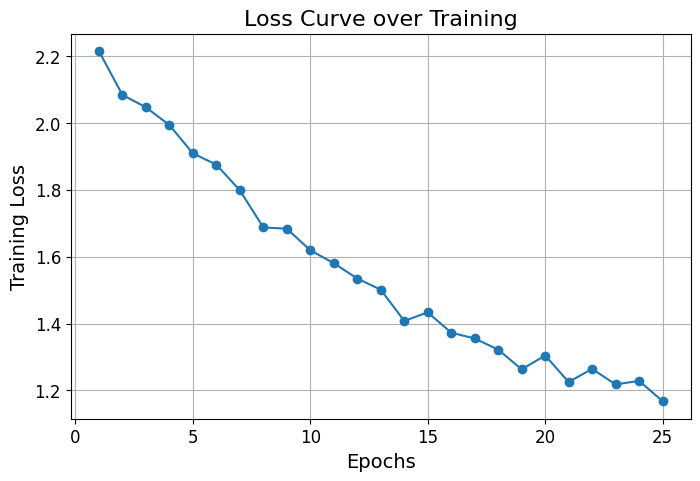

In [52]:
# Plotting the results
vector_vals = np.array(all_loss_results)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(vector_vals)+1), vector_vals, marker='o', linestyle='-')
plt.title("Loss Curve over Training", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.xticks(range(0, len(vector_vals) + 1, 5))
plt.ylabel("Training Loss", fontsize=14)
plt.grid(True)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()


# 8. IN-DOMAIN VALIDATION

### FORMAT WITH SPECIAL TOKEN

In [53]:

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place


def format_examples_validation_VAL(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset_VAL(val_dataset, num_expts=num_experiments):
    combined_dataset = []


    for irep in range(num_expts):
      for val_ex in val_dataset:

            combined_ex = {'text': '', 'label': val_ex['label'], 'exp': irep+1}


            combined_ex['text'] += val_ex['text']

            # Append the new combined example to the combined dataset
            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn_VAL(batch):
    # This function is created to be able to tokenize dynamically to max length within each batch
    # Also, by modifying the tokenizer used, several other options are available
    # for example, if we set padding to a specified max_length, for example the model max_length, is also an option, not the default though
    # the default is the dynamic padding

    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]

    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
    # tokenized_inputs = OPT_tokenizer(texts, padding="max_length", max_length = 2048, truncation=True, return_tensors="pt")

    labels_tensor = torch.tensor(labels, dtype=torch.long)
    exps_tensor = torch.tensor(exps, dtype=torch.long).to(device)

    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels_tensor,
        'exps': exps_tensor
    }


class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [54]:

formatted_val_dataset = val_dataset.map(format_examples_validation_VAL)


combined_dataset_VAL = create_combined_dataset_VAL(
                                          val_dataset = formatted_val_dataset,
                                          num_expts=num_experiments
                                           )

custom_dataset_VAL = CustomDataset(combined_dataset_VAL)
print(custom_dataset_VAL)

custom_dataset_VAL_EXP = CustomDataset([item for item in custom_dataset_VAL if item[0]['exp'] == SEL_EXP_TRAIN_CD])

# Last step, we create Dataloader passing the bx_size for inference (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_VAL = DataLoader(custom_dataset_VAL_EXP, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_VAL, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

In [55]:
for i, batch in enumerate(dataloader_VAL):
    if i<20:
      print("ORIGINAL: ", i,)
      print("TOKENIZE / DETOKENIZE: ", OPT_tokenizer.batch_decode(batch['input_ids']))
    else:
      break

ORIGINAL:  0
TOKENIZE / DETOKENIZE:  ["</s>{no it didn't} question: {Yes it did.} Yes or No? answer: Ġ"]
ORIGINAL:  1
TOKENIZE / DETOKENIZE:  ["</s>{Who? asked Tommy.} question: {Tommy didn't know, who.} Yes or No? answer: Ġ"]
ORIGINAL:  2
TOKENIZE / DETOKENIZE:  ['</s>{Paroseas cave, reef, and wreck diving around its shores, giving the diver a wide range of environments to explore.} question: {The diver has no variety in places to explore, they are monotonous. } Yes or No? answer: Ġ']
ORIGINAL:  3
TOKENIZE / DETOKENIZE:  ["</s>{um i've visited the Wyoming area i'm not sure exactly where Dances with Wolves was filmed} question: {I don't know even though I visited the area.} Yes or No? answer: Ġ"]
ORIGINAL:  4
TOKENIZE / DETOKENIZE:  ["</s>{i think Buffalo is an up an coming team they're going to they're showing some real promise for the next uh few years} question: {Buffalo is showing some real promise for the next few years, I think they are an up and coming team.} Yes or No? answer: 

In [56]:
# Set eval model for inference
# initialize to store results of model predictions and compare with ground-truth
# use generate text with only one token
# extract only the max score token YES (0 label) or NO (1 label)

example_myOPT_CD_FT.eval()

model_pred = torch.zeros(0, dtype=torch.long).to(device)
ground_truth = torch.zeros(0, dtype=torch.long).to(device)

with torch.no_grad():
    for i, batch in enumerate(dataloader_VAL):

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        gen_tokens = torch.tensor(1)
        gen_tokens = gen_tokens.to(device)


        # output only the binary yes/no,
        _, binary_yes_no, _ = example_myOPT_CD_FT.generate_text(input_ids, attention_mask, gen_tokens=gen_tokens)
        model_pred = torch.cat((model_pred, binary_yes_no), dim=0)
        ground_truth = torch.cat((ground_truth, batch['labels'].to(device)), dim=0)

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size, "PREDICTION: ", binary_yes_no, "TRUE LABELS: ", batch['labels'].detach())

accuracy_calc = (100*torch.sum(model_pred == ground_truth)/(model_pred.shape[0])).item()
print("Average Train Exp Accuracy: ", accuracy_calc)

BATCH#:  0 NUM EXPTS TOTAL:  1
BATCH#:  0 NUM EXPTS TOTAL:  1 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  1 NUM EXPTS TOTAL:  2
BATCH#:  1 NUM EXPTS TOTAL:  2 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  2 NUM EXPTS TOTAL:  3
BATCH#:  2 NUM EXPTS TOTAL:  3 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  3 NUM EXPTS TOTAL:  4
BATCH#:  3 NUM EXPTS TOTAL:  4 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  4 NUM EXPTS TOTAL:  5
BATCH#:  4 NUM EXPTS TOTAL:  5 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  5 NUM EXPTS TOTAL:  6
BATCH#:  5 NUM EXPTS TOTAL:  6 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  6 NUM EXPTS TOTAL:  7
BATCH#:  6 NUM EXPTS TOTAL:  7 PREDICTION:  tensor([0.], 

In [57]:
# Evaluate results beyond accuracy:

print("YES answer (%): ", ((torch.sum(model_pred==0))/len(model_pred)).item()*100)
print("NO  answer (%): ", ((torch.sum(model_pred==1))/len(model_pred)).item()*100)

YES answer (%):  99.4140625
NO  answer (%):  0.5859375


In [58]:

list_labels_train = []

for i, batch in enumerate(dataloader_CD_probs_exp_CDTRAIN):

    if 9904 in list(batch['OPT_idxs'][0]):
      yes_prob = batch['OPT_probs'][0][(batch['OPT_idxs'][0]==9904).nonzero(as_tuple=True)].item()
    else:
      yes_prob = 0
    if 3084 in list(batch['OPT_idxs'][0]):
      no_prob = batch['OPT_probs'][0][(batch['OPT_idxs'][0]==3084).nonzero(as_tuple=True)].item()
    else:
      no_prob = 0

    if yes_prob!=0 and no_prob!=0:
      result_to_train = ((no_prob - yes_prob)>0)*1
    else:
      result_to_train = 0.5

    list_labels_train.append(result_to_train)
print(list_labels_train)

print("YES TRAIN answer (%): ", ((torch.sum(torch.tensor(list_labels_train)==0))/len(list_labels_train)).item()*100)
print("NO  TRAIN answer (%): ", ((torch.sum(torch.tensor(list_labels_train)==1))/len(list_labels_train)).item()*100)

[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
YES TRAIN answer (%):  43.75
NO  TRAIN answer (%):  56.25


In [59]:
# Check base model output correctness (from OPT HF example)
prompt_example = ("A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the "
              "Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived "
              "there?")
prompt_example_tokenized = OPT_tokenizer(prompt_example )
example_myOPT_CD_FT.eval()
outputs_ex_sp, binary_ex_sp, scores_ex_sp = example_myOPT_CD_FT.generate_text(src_inputs = torch.unsqueeze(torch.tensor(prompt_example_tokenized['input_ids']),0).to(device),
                                    src_attn = torch.unsqueeze(torch.tensor(prompt_example_tokenized['attention_mask']),0).to(device),
                                    gen_tokens=torch.tensor(100).to(device))
OPT_tokenizer.batch_decode(outputs_ex_sp)

['</s>A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived there?\nStatue: I have lived here for over 100 years.\nHuman: What do you do?\nStatue: I am a tourist attraction.\nHuman: What do you do when you are not a tourist attraction?\nStatue: I am a tourist attraction.\nHuman: What do you do when you are not a tourist attraction?\nStatue: I am a tourist attraction.\nHuman: What do you do when you are not a tourist attraction?\nStatue:']

# 9. OUT OF DOMAIN VALIDATION

In [60]:
dataset_ood = load_dataset("hans")
dataset_ood

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
        num_rows: 30000
    })
})

In [61]:
dataset_ood_val = (dataset_ood['validation']).filter(lambda example: example["heuristic"] == 'lexical_overlap')

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [62]:

random_split_seed_ood = 42 # set above, equal to 42

examples_per_exp =  examples_per_exp # 16
num_experiments = num_experiments # 10
num_validations = num_validations # 16*64 #64*16 = 1024 #6692

np.random.seed(random_split_seed_ood)
indices_ood_val = np.random.choice(range(len(dataset_ood_val)), size=num_validations, replace=False)
print("indices_ood_val: ", indices_ood_val)

dataset_ood_val_sel = dataset_ood_val.select(indices_ood_val)
dataset_ood_val_sel

indices_ood_val:  [6252 4684 1731 ... 9410 1671  474]


Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 1024
})

In [63]:

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place


def format_examples_validation_VALOOD(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset_VALOOD(val_dataset, num_expts=num_experiments):
    combined_dataset = []

    for irep in range(num_expts):
      for val_ex in val_dataset:

            combined_ex = {'text': '', 'label': val_ex['label'], 'exp': irep+1}

            # Add the example to predict (validation)
            combined_ex['text'] += val_ex['text']

            # Append the new combined example to the combined dataset
            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn_VALOOD(batch):
    # This function is created to be able to tokenize dynamically to max length within each batch
    # Also, by modifying the tokenizer used, several other options are available
    # for example, if we set padding to a specified max_length, for example the model max_length, is also an option, not the default though
    # the default is the dynamic padding

    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]

    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
    # tokenized_inputs = OPT_tokenizer(texts, padding="max_length", max_length = 2048, truncation=True, return_tensors="pt")

    labels_tensor = torch.tensor(labels, dtype=torch.long)
    exps_tensor = torch.tensor(exps, dtype=torch.long).to(device)

    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels_tensor,
        'exps': exps_tensor
    }


class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [64]:


formatted_val_dataset_ood = dataset_ood_val_sel.map(format_examples_validation_VALOOD)


combined_dataset_VALOOD = create_combined_dataset_VALOOD(
                                          val_dataset = formatted_val_dataset_ood,
                                          num_expts=num_experiments
                                           )

custom_dataset_VALOOD = CustomDataset(combined_dataset_VALOOD)
print(custom_dataset_VALOOD)

custom_dataset_VALOOD_EXP = CustomDataset([item for item in custom_dataset_VALOOD if item[0]['exp'] == SEL_EXP_TRAIN_CD])

# Last step, we create Dataloader passing the bx_size for inference (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_VALOOD = DataLoader(custom_dataset_VALOOD_EXP, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_VALOOD, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

In [65]:


example_myOPT_CD_FT.eval()

model_pred = torch.zeros(0, dtype=torch.long).to(device)
ground_truth = torch.zeros(0, dtype=torch.long).to(device)

with torch.no_grad():
    for i, batch in enumerate(dataloader_VALOOD):

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        gen_tokens = torch.tensor(1)
        gen_tokens = gen_tokens.to(device)


        # output only the binary yes/no,
        _, binary_yes_no, _ = example_myOPT_CD_FT.generate_text(input_ids, attention_mask, gen_tokens=gen_tokens)
        model_pred = torch.cat((model_pred, binary_yes_no), dim=0)
        ground_truth = torch.cat((ground_truth, batch['labels'].to(device)), dim=0)

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size, "PREDICTION: ", binary_yes_no, "TRUE LABELS: ", batch['labels'].detach())

accuracy_calc = (100*torch.sum(model_pred == ground_truth)/(model_pred.shape[0])).item()
print("Average OOD Experiment Accuracy: ", accuracy_calc)

BATCH#:  0 NUM EXPTS TOTAL:  1
BATCH#:  0 NUM EXPTS TOTAL:  1 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  1 NUM EXPTS TOTAL:  2
BATCH#:  1 NUM EXPTS TOTAL:  2 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  2 NUM EXPTS TOTAL:  3
BATCH#:  2 NUM EXPTS TOTAL:  3 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  3 NUM EXPTS TOTAL:  4
BATCH#:  3 NUM EXPTS TOTAL:  4 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  4 NUM EXPTS TOTAL:  5
BATCH#:  4 NUM EXPTS TOTAL:  5 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  5 NUM EXPTS TOTAL:  6
BATCH#:  5 NUM EXPTS TOTAL:  6 PREDICTION:  tensor([0.], device='cuda:0', dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  6 NUM EXPTS TOTAL:  7
BATCH#:  6 NUM EXPTS TOTAL:  7 PREDICTION:  tensor([0.], 

In [66]:
# Evaluate results beyond accuracy:

print("YES answer (%): ", ((torch.sum(model_pred==0))/len(model_pred)).item()*100)
print("NO  answer (%): ", ((torch.sum(model_pred==1))/len(model_pred)).item()*100)

YES answer (%):  100.0
NO  answer (%):  0.0
